## Spatial Agg Velo'v

In [2]:
import sys
import os
import pandas as pd
import geopandas as gpd
from shapely.ops import unary_union

import torch
import numpy as np
from datetime import datetime
import pickle 
# --- Gestion de l'arborescence ---
current_file_path = os.path.abspath(os.path.dirname(os.getcwd()))
parent_dir = os.path.abspath(os.path.join(current_file_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# --- Importations personnalisées ---
from dataset import DataSet, PersonnalInput
from utils.utilities import filter_args # Assurez-vous que ce chemin est correct
from build_inputs.load_preprocessed_dataset import load_input_and_preprocess


DATA_PATH = "/home/rrochas/../../../data/rrochas/prediction_validation"

def aggregate_iris_zones(init_gdf: gpd.GeoDataFrame, target_n: int, save_path:str = None) -> gpd.GeoDataFrame:
    """
    Agrège les zones IRIS d'un GeoDataFrame jusqu'à atteindre au plus target_n zones.
    L'agrégation minimise le critère (s_i + s_j) / P_ij entre zones adjacentes.
    Où P_ij est la longueur de la portion de perimètre commune entre deux zones.

    Paramètres:
        gdf: GeoDataFrame avec colonnes 'INSEE_COM', 'IRIS', 'CODE_IRIS', 'NEIGHBORS', 'STATION', 'geometry', etc.
        target_n: nombre cible de zones après agrégation.

    Retour:
        GeoDataFrame agrégé.
    """
    gdf = init_gdf.copy()
    gdf.crs = 'EPSG:4326' 
    gdf = gdf.to_crs('EPSG:2154')  # Projection Lambert-93
    # Conversion des types
    gdf['INSEE_COM'] = gdf['INSEE_COM'].astype(int)
    gdf['IRIS'] = gdf['IRIS'].astype(int)
    gdf['CODE_IRIS'] = gdf['CODE_IRIS'].astype(int)
    gdf['CONTAINS'] = gdf['CODE_IRIS'].apply(lambda x: [x])
    # Parsing de la colonne NEIGHBORS
    gdf['NEIGHBORS'] = gdf['NEIGHBORS'].apply(
        lambda s: list(map(int, s.split(','))) if isinstance(s, str) and s else []
    )
    gdf['STATION'] = gdf['STATION'].apply(
        lambda s: list(map(int, s.split(' '))) if isinstance(s, str) and s else []
    )
    gdf['area'] = gdf.geometry.area/ 1e6  # Convertir en km²
    gdf.set_index('CODE_IRIS', inplace=True)
    gdf[['best_score','best_neighbor']] = pd.DataFrame(gdf.apply(lambda row: compute_score(row,gdf),axis=1).tolist(),columns=['best_score','best_neighbor'],index=gdf.index)


    # Boucle principale
    while len(gdf) > target_n:
        gdf,_ = iteration_spatial_agg(gdf)

    gdf['NEIGHBORS'] = gdf['NEIGHBORS'].apply(lambda x: ','.join(map(str, x)))
    gdf['STATION'] = gdf['STATION'].apply(lambda x: ' '.join(map(str, x)))
    gdf['CONTAINS'] = gdf['CONTAINS'].apply(lambda x : ','.join(list(map(str,x))))

    # Save gdf: 
    if save_path is not None: 
        dir_path = f"{save_path}/lyon_iris_agg{target_n}"
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)
        gdf.to_file(f"{dir_path}/lyon.shp")
    return gdf



def compute_score(row,gdf,agg_per_IRIS_type = False):
    # Init score:
    best_score = float('inf')
    best_neighbor = None
    
    # Compute: 
    area_i = row['area']
    geom_i = row.geometry

    for iris_code in row['NEIGHBORS']:
        row_j = gdf.loc[iris_code]
        common = geom_i.union(row_j.geometry)


        common_zone_type = True if not agg_per_IRIS_type else (row['TYP_IRIS'] == row_j['TYP_IRIS'])
            

        ## Common Perimeter: 
        # perim = common.length/1e3  # Convertir en km
        intersection = geom_i.intersection(row_j.geometry)
        common_perimeter = intersection.length / 1e3  # in Km 
        area = area_i + row_j['area']
        if common_perimeter > 1e-9 and common_zone_type:
            score = (area) / common_perimeter
        else:
            score = np.inf


        if score < best_score:
            best_score = score
            best_neighbor = iris_code

    return best_score,best_neighbor
        
def iteration_spatial_agg(gdf):
    
    ## Find index of the best score (i.e min score):
    two_best_scores = gdf['best_score'].nsmallest(2)
    assert abs(two_best_scores.iloc[0] - two_best_scores.iloc[1])<1e-3, f"two_best_scores.iloc[0] = {two_best_scores.iloc[0]} and  two_best_scores.iloc[0] = {two_best_scores.iloc[1]}"
    best_score_index = list(two_best_scores.index)
    aggregated_rows = gdf.loc[best_score_index].copy()
    # print('Best score: ')
    # display(two_best_scores)


    # ------- Merge 2 rows:  ---------------------------------------------------------------
    row1 = gdf.loc[best_score_index[0]]
    row2 = gdf.loc[best_score_index[1]]
    row = row1.copy()

    # Update Neighbors, Station & Geometry:
    row.NEIGHBORS = list((set(row1.NEIGHBORS) | set(row2.NEIGHBORS)) - set([row1.name,row2.name]))
    row.STATION = list((set(row1.STATION) | set(row2.STATION)))
    row.geometry = row1.geometry.union(row2.geometry)
    row.CONTAINS = row.CONTAINS + row2.CONTAINS
    # row.geometry = unary_union([row_i.geometry, row_j.geometry]).convex_hull
    row['area'] = row.geometry.area /1e6


    ## Remove row2 and row1 from gdf: 
    gdf.drop(index=best_score_index[0], inplace=True)
    gdf.drop(index=best_score_index[1], inplace=True)

    ## Add row to gdf:
    gdf.loc[row.name] = row

    # print('row1.name: ', row1.name)
    # print('row2.name: ', row2.name)
    # print('All neighbords: ', row2.NEIGHBORS)

    # ------- Update Names: replace neighbor2 to the name of neighor1 in the gdf  -------------------------
    gdf_neighbords = gdf.copy()
    for neighbor in row2.NEIGHBORS:
        # If neighbor is not in row1.NEIGHBORS, add it:
        if neighbor != row1.name : 
            # print('\nneighbor: ', neighbor)
            # print("gdf.loc[neighbor, 'NEIGHBORS'] before: ", gdf.loc[neighbor, 'NEIGHBORS'])
            new_neighbors = list(set(gdf_neighbords.loc[neighbor]['NEIGHBORS'] + [row1.name]) - set([row2.name]) )
            gdf.at[neighbor, 'NEIGHBORS'] = new_neighbors
            # print("gdf.loc[neighbor, 'NEIGHBORS'] after: ", gdf.loc[neighbor]['NEIGHBORS'] )


    # -------  Compute New scores for the New aggregated row and all the concerned neighbors -------------------------
    updated_best_score,updated_best_neighbor = compute_score(row, gdf)
    gdf.loc[row.name,'best_score'] = updated_best_score
    gdf.loc[row.name,'best_neighbor'] = updated_best_neighbor

    # print('\nRow IRIS: ',row.name)
    # print('Row Neighbors: ',row.NEIGHBORS)
    # print('Best Neighbor among them: ',row['best_neighbor'])


    # Compute new best_score and best_neighbor of each neighbor :
    for neighbor in row.NEIGHBORS:
        best_score, best_neighbor = compute_score(gdf.loc[neighbor], gdf)
        # gdf.loc[neighbor, 'best_score'] = best_score
        # gdf.loc[neighbor, 'best_neighbor'] = best_neighbor
        gdf.at[neighbor, 'best_score']= best_score
        gdf.at[neighbor, 'best_neighbor']= best_neighbor

    gdf.crs = 'EPSG:2154'
    return gdf,aggregated_rows


def get_dic_contained_index(gdf_init,gdf_agg,save_path = None):
    gdf_agg['CONTAINS'] = gdf_agg['CONTAINS'].apply(lambda x : list(map(int,x.split(','))))
    gdf_agg['Idx_in_init'] = gdf_agg['CONTAINS'].apply(lambda L_iris_id : get_index_from_iris_ids(L_iris_id,gdf_init))

    dictionnary_aggregated_iris = {}
    for idx,row in gdf_agg.iterrows():
        dictionnary_aggregated_iris[idx] = row['Idx_in_init']
    if save_path is not None:
        target_n = len(gdf_agg)
        save_path = f"{save_path}/dic_lyon_iris_agg{target_n}.pkl"
        pickle.dump(dictionnary_aggregated_iris,open(save_path,"wb"))
    return dictionnary_aggregated_iris


def get_index_from_iris_ids(L_iris_id,iris_gdf):
    gdf_i = iris_gdf.copy()
    return list(gdf_i[gdf_i.CODE_IRIS.isin(L_iris_id)].index)


## Generate Aggregated IRIS gdf:

In [ ]:

iris_path = f"{DATA_PATH}/lyon_iris_shapefile/lyon.shp"
iris_gdf = gpd.read_file(iris_path)
target_n = 100


agg_gdf = aggregate_iris_zones(iris_gdf, target_n, save_path = DATA_PATH)
dictionnary_aggregated_iris = get_dic_contained_index(iris_gdf,agg_gdf,save_path = DATA_PATH)

agg_gdf.head(2)

/tmp/ipykernel_6131/1293071037.py:69: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(f"{dir_path}/lyon.shp")


,INSEE_COM,NOM_COM,IRIS,NOM_IRIS,TYP_IRIS,x,y,NEIGHBORS,STATION,geometry,CONTAINS,area,best_score,best_neighbor,Idx_in_init
CODE_IRIS,,,,,,,,,,,,,,,
692560702,69256,Vaulx-en-Velin,702,Dumas-Genas,H,4.927895,45.752268,"692661602,692560701,692750109,690290102",12003,"POLYGON ((849528.300 6518224.900, 849392.200 6...",[692560702],1.525888,2.488023,692560701,[7]
692040103,69204,Saint-Genis-Laval,103,Basses Barolles,H,4.787730,45.675048,"692040202,692040102",,"POLYGON ((839287.700 6508882.800, 839277.200 6...",[692040103],1.467854,5.686247,692040102,[10]


In [37]:
tag = 'iris'
app = 'Web_Weather'
mode = 'DL'
folder_path_to_save_agg_data = f"/home/rrochas/../../../data/rrochas/prediction_validation/POIs/netmob_POI_Lyon/Inputs/agg_TS/{tag}/{app}/{mode}"
loaded_data = torch.Tensor(np.load(open(f"{folder_path_to_save_agg_data}/data.npy","rb")))

target_n = 50
dic_path = f"/home/rrochas/../../../data/rrochas/prediction_validation/dic_lyon_iris_agg{target_n}.pkl"
dictionnary_aggregated_iris = pickle.load(open(dic_path,'rb'))
loaded_data_bis = torch.empty(target_n,loaded_data.size(-1))

for k,(key,list_idx) in enumerate(dictionnary_aggregated_iris.items()):
    loaded_data_bis[k] = torch.index_select(loaded_data,0,torch.tensor(list_idx).long()).mean(0)

<Axes: >

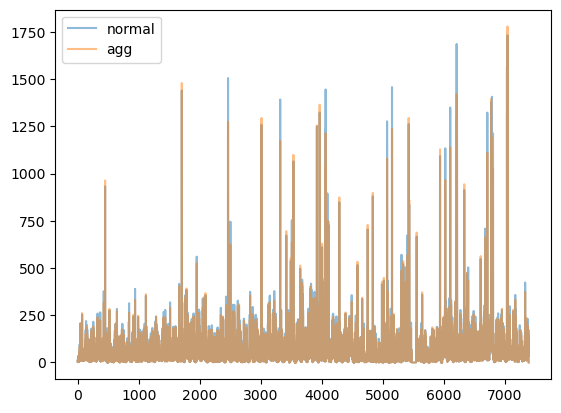

In [56]:
i = 12
pd.DataFrame(dict(normal = loaded_data[dictionnary_aggregated_iris[691430101][0]], 
                  agg = loaded_data_bis[i,:].numpy()
                  )).plot(alpha= 0.5)

In [52]:
dictionnary_aggregated_iris

{692040103: [10],
 692020402: [15],
 691430103: [133],
 692900701: [190],
 691430102: [214],
 692900702: [267],
 692900201: [305],
 692750111: [353],
 690680000: [363],
 692750110: [395],
 690030000: [413],
 692560101: [424],
 691430101: [141, 198],
 692440203: [8, 254],
 693890604: [228, 417],
 693830402: [24, 230, 255, 332],
 692900502: [237, 341],
 693850601: [23, 95, 106, 250],
 692040202: [129, 169, 323, 334],
 692440102: [11, 258],
 692020103: [68, 89, 284, 344, 400],
 691520104: [45, 52, 107, 282, 352],
 692750106: [2, 83, 86, 92, 304, 369, 374, 405],
 690340104: [28,
  55,
  67,
  91,
  103,
  135,
  176,
  181,
  182,
  191,
  227,
  236,
  242,
  273,
  280,
  289,
  354,
  360,
  383,
  389,
  426],
 692590801: [156, 229, 233, 338],
 691910102: [139, 147],
 691940101: [132, 218, 317],
 693820501: [1, 76, 98, 126, 161, 207, 211, 279, 328, 359, 371, 396, 403],
 693880501: [50,
  53,
  70,
  78,
  128,
  152,
  184,
  185,
  288,
  295,
  310,
  327,
  330,
  337,
  345,
  373,

## How to know which Nodes we have to aggregate:

In [11]:
target_n = 100
iris_path = f"{DATA_PATH}/lyon_iris_shapefile/lyon.shp"
iris_agg_path = f"{DATA_PATH}/lyon_iris_agg{target_n}/lyon.shp"

iris_gdf = gpd.read_file(iris_path)
iris_agg = gpd.read_file(iris_agg_path)

## Load Velo'V Dataset:

In [12]:
iris_path = f"{DATA_PATH}/lyon_iris_shapefile/lyon.shp"
velov_json = f"{DATA_PATH}/pvo_patrimoine_voirie.pvostationvelov.json"

velov_gdf = gpd.read_file(velov_json)
iris_gdf = gpd.read_file(iris_path)

display(velov_gdf.head(2))
display(iris_gdf.head(2))



# --- Constantes spécifiques à cette donnée ---
FOLDER_PATH = os.path.expanduser('~/../../../data/rrochas/prediction_validation') # Chemin vers le dossier contenant les données
NAME = 'bike_in'
FILE_BASE_NAME = 'velov'
DIRECTION = 'attracted' #'attracted' # emitted
FILE_PATTERN = f'velov_{DIRECTION}_by_station' # Sera complété par args.freq
DATA_SUBFOLDER = 'agg_data/velov' # Sous-dossier dans FOLDER_PATH


# Couverture théorique
START = '2019-01-01' 
END = '2020-01-01'
USELESS_DATES = {'hour':[], #[1,2,3,4,5,6],  #[] if no useless (i.e removed) hours
                 'weekday':[]#[5,6],
                 }
# Liste des périodes invalides
list_of_invalid_period = []

C = 1 # Nombre de canaux/features par unité spatiale

# Colonnes attendues dans le CSV
if DIRECTION == 'emitted':
    DATE_COL = 'date_sortie' 
    LOCATION_COL = 'id_sortie' # Ou 'id_entree' pour 'attracted'?
    VALUE_COL = 'volume'
else:
    DATE_COL = 'date_retour' 
    LOCATION_COL = 'id_retour' # Ou 'id_entree' pour 'attracted'?
    VALUE_COL = 'volume'

target_freq = '15min'
# Construction spécifique du nom de fichier pour velov
file_name = f"{FILE_PATTERN}{target_freq}"
data_file_path = os.path.join(FOLDER_PATH, DATA_SUBFOLDER, f"{file_name}.csv")

print(f"Chargement des données depuis : {data_file_path}")
try:
    df = pd.read_csv(data_file_path)
except FileNotFoundError:
    print(f"ERREUR : Le fichier {data_file_path} n'a pas été trouvé.")
    print(f"Vérifiez que la fréquence '{target_freq}' existe pour velov_{DIRECTION} et que les chemins sont corrects.")
except Exception as e:
    print(f"ERREUR lors du chargement du fichier {file_name}.csv: {e}")

,idstation,nom,adresse1,adresse2,commune,numdansarrondissement,nbbornettes,stationbonus,pole,ouverte,achevement,gid,code_insee,geometry
0,7024,Bancel / Chevreul,Rue Bancel,Rue Chevreul,Lyon 7 ème,24.0,21.0,,Itinéraire cyclable,Oui,,1,69387,POINT (4.84052 45.74852)
1,10063,Perrin / Jean Jaurès,"9, Place Jules Grandclément",Rue Antonin Perrin,VILLEURBANNE,63.0,34.0,,quartier Grandclément,Oui,,2,69266,POINT (4.88561 45.75839)


,INSEE_COM,NOM_COM,IRIS,CODE_IRIS,NOM_IRIS,TYP_IRIS,x,y,NEIGHBORS,STATION,geometry
0,69286.0,Rillieux-la-Pape,202.0,692860202.0,Mont Blanc,H,4.895028,45.810221,"692860402,692860102,692860301,692860201",None,"POLYGON ((4.89204 45.81283, 4.89271 45.81305, ..."
1,69382.0,Lyon 2e Arrondissement,501.0,693820501.0,Montrochet-Marché-Gare,A,4.818996,45.738332,"693870103,693850104,693820503,691420102,693820...",2020 2005 2009 2019,"POLYGON ((4.82108 45.75066, 4.82109 45.75066, ..."


Chargement des données depuis : /home/rrochas/../../../data/rrochas/prediction_validation/agg_data/velov/velov_attracted_by_station15min.csv


In [ ]:
s_zone2stations_path = f"{DATA_PATH}/lyon_iris_agg{target_n}/zone2stations.csv"
s_zone2stations = iris_agg['STATION'][~iris_agg['STATION'].isna()]


# Save: 
if False:
    s_zone2stations.to_csv(s_zone2stations_path)


## Load bike
### Permet de tester si les sauvegarde le sont au bon endroit et que le loading est fonctionnel:  

In [15]:
from build_inputs.load_preprocessed_dataset import load_input_and_preprocess
coverage_period = pd.date_range(start = START, end = END, freq = target_freq )

df[DATE_COL] = pd.to_datetime(df[DATE_COL])

# Pivoter le DataFrame
df_pivoted = df.pivot_table(index=DATE_COL, columns=LOCATION_COL, values=VALUE_COL, aggfunc='sum')

# Remplacer les NaN par 0
df_pivoted = df_pivoted.fillna(0)

# S'assurer que l'index est un DatetimeIndex
df_pivoted.index = pd.to_datetime(df_pivoted.index)

# Filtrage temporel basé sur l'intersection
df_filtered = df_pivoted[df_pivoted.index.isin(coverage_period)].copy()


print(f"Données filtrées. Dimensions: {df_filtered.shape}")


# --- Création et Prétraitement avec PersonnalInput ---
threshold_volume_min = 1

#Load Data: 
s_zone2stations_path = f"{FOLDER_PATH}/lyon_iris_agg{target_n}/zone2stations.csv"
s_zone2stations = pd.read_csv(s_zone2stations_path,index_col = 0)

agg_df = pd.DataFrame(columns = s_zone2stations.index)
for idx,row in s_zone2stations.iterrows():
    station_id = row.STATION
    columns = list(map(int,station_id.split(' ')))
    effective_columns = [c for c in columns if c in df_filtered.columns]
    agg_df[idx] = df_filtered[effective_columns].sum(axis=1)

print(f"Données Aggrégée: {agg_df.shape}")
mask = agg_df.mean() > threshold_volume_min
df_filtered = agg_df.T[mask].T
print(f"Données Aggrégée + Filtrée: {df_filtered.shape}")

# Conversion en Tensor
data_T = torch.tensor(df_filtered.values).float()

Données filtrées. Dimensions: (35030, 435)
Données Aggrégée: (35030, 59)
Données Aggrégée + Filtrée: (35030, 26)


## Visualisation of zones we just built: 

In [16]:
iris_agg['volume'] = df_filtered.sum()
# iris_agg['volume'][iris_agg['volume'].isna()] = 0
iris_agg.explore('volume')